#  Support Vector Machines

El método SVM es un algoritmo de aprendizaje automático utilizado para clasificación y regresión. Funciona buscando encontrar un hiperplano en un espacio de características que maximice la separación entre diferentes categorías de datos.

Para encontrar el hiperplano óptimo, el SVM utiliza un concepto llamado margen. El margen es la distancia mínima entre el hiperplano y los vectores más cercanos de cada categoría. Al maximizar el margen, se logra una mayor precisión en la clasificación de nuevos datos.

\begin{align*}
\max _{\boldsymbol{w}, b} & \min \left\{\left|\boldsymbol{x}-\boldsymbol{x}_i\right|_2^2 \mid \boldsymbol{w}^T \boldsymbol{x}+b=0, i=1, \ldots, L\right\} \\
\text { s.t. } & \boldsymbol{w}^T \boldsymbol{x}_j+b \geq 1, j=1, \ldots, L^{+} \\
& \boldsymbol{w}^T \boldsymbol{x}_k+b \leq-1, k=1, \ldots, L^{-}
\end{align*}

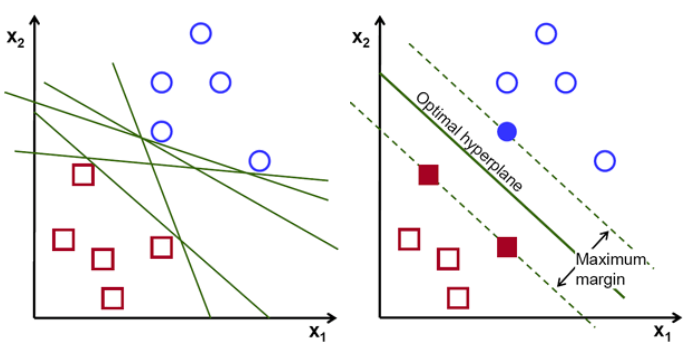

In [600]:
# install library
# ! pip install cvxpy


In [601]:
# imports
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.colors as co
from scipy.optimize import minimize


## Basic SV

#### Dataset


In [602]:
X, y = make_blobs(100, centers=2, n_features=2, random_state=50)
y = y * 2 - 1


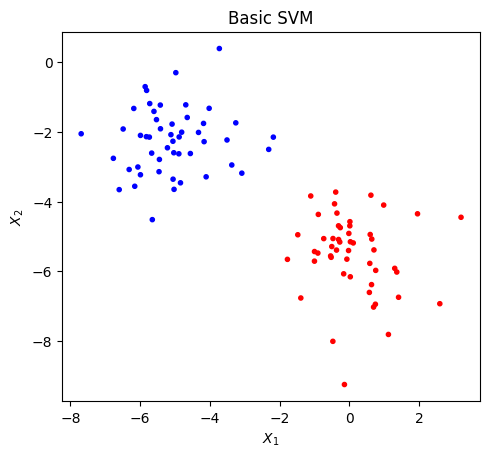

In [603]:

plt.title("Basic SVM")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=co.ListedColormap(['red', 'blue']), marker='.')
plt.axis("scaled")
plt.show()


#### SVM Primal 


\begin{align*}
\min &\frac{1}{2}{\|\mathbf w\|}^2_2\\
\text{s.t. } &y_i(\mathbf w^T x_i + b) \ge 1, i = 1, \dots, L
\end{align*}


In [604]:
def svm_prim_sep(X: np.ndarray, y: np.ndarray):
    m, n = X.shape
    # Declaración de variables
    w = cp.Variable(n)
    b = cp.Variable()
    # Define la función objetivo
    objective = cp.Minimize(cp.sum_squares(w) / 2)
    # Define las restricciones del problema
    constraints = [cp.multiply(y, X @ w + b) >= 1]
    # Resuelve el problema de optimización
    problem = cp.Problem(objective, constraints)
    problem.solve()
    # Retorna los resultados
    return w.value, b.value


In [605]:
w_primal, b_primal = svm_prim_sep(X, y)
print(f"w={w_primal}, b={b_primal}")


w=[-0.74427958  0.82511402], b=1.3451712437423715


#### SVM dual

\begin{align*}
\max _{\boldsymbol{\alpha}} & \sum_{i=1}^L \alpha_i-\frac{1}{2} \sum_{i=1}^L \sum_{j=1}^L y_i y_j \alpha_i \alpha_j \boldsymbol{x}_i^T \boldsymbol{x}_j \\
\text { s.t. } & \alpha_i \geq 0 \\
& \sum_{i=1}^L \alpha_i y_i=0
\end{align*}

In [606]:
def svm_dual_sep(X, y):
    num, _ = X.shape
    H = (X @ X.T) * (np.outer(y, y))

    # Define la función objetivo
    objective = lambda alpha: -np.sum(alpha) + alpha @ (H @ alpha) / 2

    # Define las restricciones del problema
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x},   # alpha >= 0
        {'type': 'eq', 'fun': lambda x: y @ x}, # y @ alpha == 0
    ]

    # Resuelve el problema de optimización
    res = minimize(objective, np.zeros(num), constraints=constraints)

    # Obtiene los resultados
    alpha = res.x
    sv_ind = alpha > 1e-4
    w = X.T @ (alpha * y)
    b = np.mean(y[sv_ind] - X[sv_ind, :] @ w)
    return w, b, alpha


In [607]:
w_dual, b_dual, _ = svm_dual_sep(X, y)
print(f"w={w_dual}, b={b_dual}")


w=[-0.74402098  0.82482734], b=1.3447038633814026


#### Usando SKLearn

In [608]:
from sklearn.svm import SVC
svm = SVC(gamma='scale', kernel='linear')
svm.fit(X, y)
print(f"w={svm.coef_[0]}, b={svm.intercept_}")


w=[-0.74427943  0.82511386], b=[1.34517102]


#### Graficando resultados

In [609]:
def f(x, shift=0): 
    return 1 / w_primal[1] * (shift - b_primal - x * w_primal[0])


def g(x, shift=0):
    return x * w_primal[1] / w_primal[0]


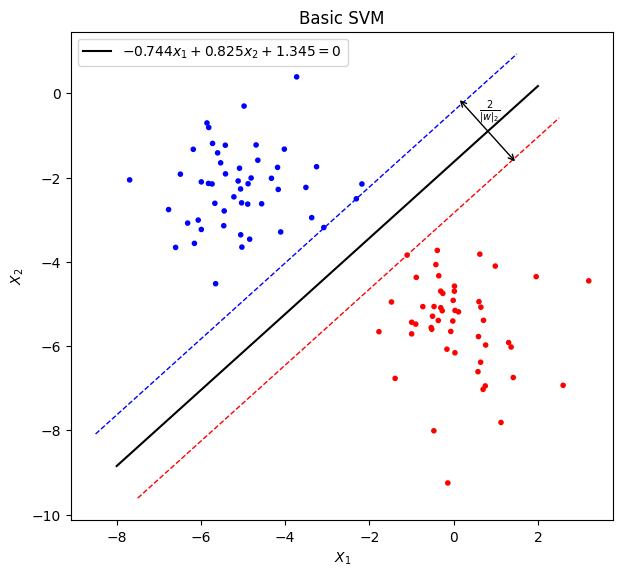

In [610]:
plt.figure(figsize=(7, 7))
plt.title("Basic SVM")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=co.ListedColormap(['red', 'blue']), marker='.')
# blue line
plt.plot([-8.5, 1.5], [f(-8.5, 1), f(1.5, 1)], c='blue', linestyle='--', linewidth=1.0)
# black line
plt.plot([-8, 2], [f(-8), f(2)], c='black', label=f'${w_primal[0]:0.3f}x_1+{w_primal[1]:0.3f}x_2 + {b_primal:0.3f} = 0$')
# red line
plt.plot([-7.5, 2.5], [f(-7.5, -1), f(2.5, -1)], c='red', linestyle='--', linewidth=1.0)
# perpendicular arrow
plt.annotate("", xy=(0.1, g(0.1)), xytext=(1.5, g(1.5)), arrowprops=dict(arrowstyle="<->"))
plt.text(0.6, -0.5, "$\\frac{2}{|w|_2}$")
plt.legend()
plt.axis("scaled")
plt.show()


## Soft Margin SVM 



In [632]:
C = 1/2


#### SVM Soft Margin  

\begin{align*}
\min _{\boldsymbol{w}, b, \xi_i} & \frac{1}{2}|\boldsymbol{w}|_2^2+C \sum_{i=1}^L \xi_i\\
\text { s.t. } & y_i\left(\boldsymbol{w}^T \boldsymbol{x}_i+b\right) \geq 1-\xi_i, i=1, \ldots, L \\
& \xi_i \geq 0, i=1, \ldots, L
\end{align*}

In [633]:
def svm_prim_nonsep2(X: np.ndarray, y: np.ndarray, C: float):
    num, dim = X.shape
    w = cp.Variable(dim)
    b = cp.Variable()
    xi = cp.Variable(num)
    objective = cp.Minimize(cp.sum_squares(w) / 2 + C * cp.sum(xi))
    constraints = [cp.multiply(y, X @ w + b) >= 1 - xi,
                   xi >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value, b.value


In [634]:
w_soft_primal, b_soft_primal = svm_prim_nonsep2(X, y, C=1/2)
print(f"w={w_soft_primal}, b={b_soft_primal}")


w=[-0.60770794  0.66923081], b=1.2579738049910625


#### SVM Soft Margin Dual 

\begin{align*}
\max _{\boldsymbol{\alpha}} & \sum_{i=1}^L \alpha_i-\frac{1}{2} \sum_{i=1}^L \sum_{j=1}^L y_i y_j \alpha_i \alpha_j \boldsymbol{x}_i^T \boldsymbol{x}_j \\
\text { s.t. } &  0 \le \alpha_i \le C \\
& \sum_{i=1}^L \alpha_i y_i=0
\end{align*}

In [635]:
def svm_dual_sep(X, y):
    num, _ = X.shape
    H = (X @ X.T) * (np.outer(y, y))

    # Define la función objetivo
    objective = lambda alpha: -np.sum(alpha) + alpha @ (H @ alpha) / 2

    # Define las restricciones del problema
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x},   # alpha >= 0
        {'type': 'eq', 'fun': lambda x: y @ x}, # y @ alpha == 0
    ]

    # Resuelve el problema de optimización
    res = minimize(objective, np.zeros(num), constraints=constraints)

    # Obtiene los resultados
    alpha = res.x
    sv_ind = alpha > 1e-4
    w = X.T @ (alpha * y)
    b = np.mean(y[sv_ind] - X[sv_ind, :] @ w)
    return w, b, alpha


In [636]:
def svm_dual_nonsep2(X, y, C):
    num, _ = X.shape
    H = np.multiply(X @ X.T, np.outer(y, y))

    # Define la función objetivo
    def objective(alpha):
        return -np.sum(alpha) + alpha @ (H @ alpha) / 2

    # Define las restricciones del problema
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x},  # alpha >= 0
        {'type': 'ineq', 'fun': lambda x: C - x},  # alpha >= 0
        {'type': 'eq', 'fun': lambda x: y @ x},  # labels.T @ alpha == 0
    ]

    # Resuelve el problema de optimización
    res = minimize(objective, np.zeros(num), constraints=constraints)

    # Obtiene los resultados
    alpha = res.x
    sv_ind = alpha > 1e-4
    w = X.T @ (alpha * y)
    xi = alpha / (2 * C)
    b = np.mean(y[sv_ind] * (1 - xi[sv_ind]) - X[sv_ind, :] @ w)
    return w, b, alpha


In [637]:
w_soft_dual, b_soft_dual, _ = svm_dual_nonsep2(X, y, C)
print(f"w={w_soft_dual}, b={b_soft_dual}")



w=[-0.60770784  0.66923079], b=1.1710548276401533


#### Usando SKLearn

In [638]:
from sklearn.svm import SVC
svm = SVC(gamma='scale', kernel='linear', C=C)
svm.fit(X, y)
print(f"w={svm.coef_[0]}, b={svm.intercept_}")



w=[-0.60770817  0.66923086], b=[1.25797346]


#### Graficando resultados

In [639]:
def f_soft(x, shift=0): 
    return 1 / w_soft_primal[1] * (shift - b_soft_primal - x * w_soft_primal[0])


def g_soft(x, shift=0):
    return x * w_soft_primal[1] / w_soft_primal[0]


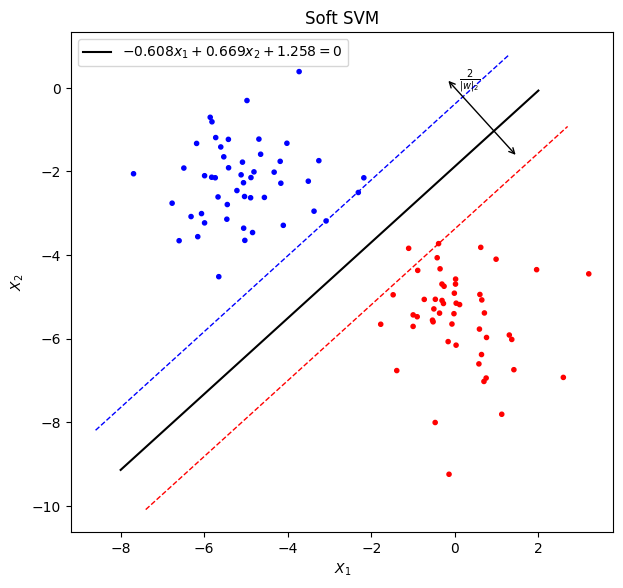

In [640]:
plt.figure(figsize=(7, 7))
plt.title("Soft SVM")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=co.ListedColormap(['red', 'blue']), marker='.')
# blue line
plt.plot([-8.6, 1.3], [f_soft(-8.6, 1), f_soft(1.3, 1)], c='blue', linestyle='--', linewidth=1.0)
# black line
plt.plot([-8, 2], [f_soft(-8), f_soft(2)], c='black', label=f'${w_soft_primal[0]:0.3f}x_1+{w_soft_primal[1]:0.3f}x_2 + {b_soft_primal:0.3f} = 0$')
# red line
plt.plot([-7.4, 2.7], [f_soft(-7.4, -1), f_soft(2.7, -1)], c='red', linestyle='--', linewidth=1.0)
# perpendicular arrow
plt.annotate("", xy=(-0.2, g_soft(-0.2)), xytext=(1.5, g_soft(1.5)), arrowprops=dict(arrowstyle="<->"))
plt.text(0.1, 0.1, "$\\frac{2}{|w|_2}$")
plt.legend()
plt.axis("scaled")
plt.show()


### Bibliografía

[1] Li, L. (2015). *Selected applications of convex optimization* (Vol. 103). Berlin, Germany: Springer.